In [26]:
import torch
import os

In [27]:
root_dir = "/om2/user/yyf/YouTube-VIS/train/JPEGImages/" 
dirs = os.listdir(root_dir)

IndexError: index 20 is out of bounds for axis 0 with size 20

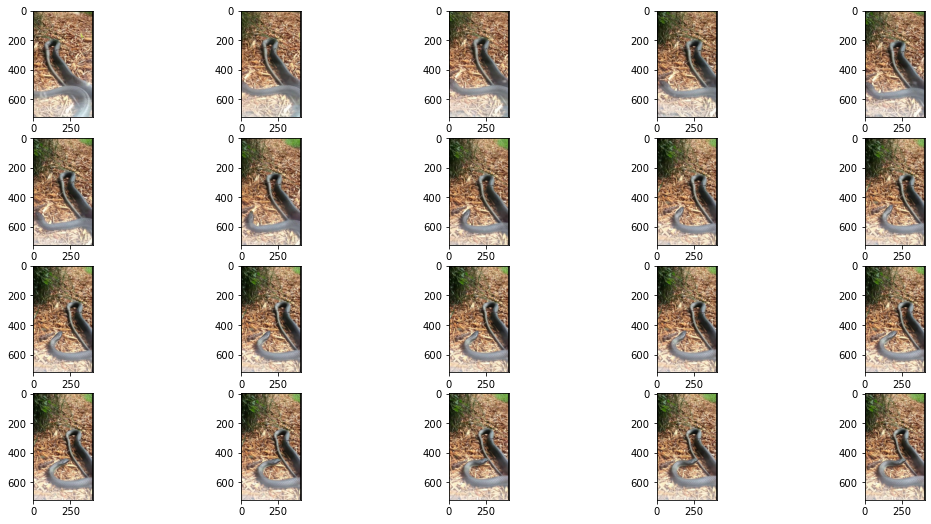

In [35]:
from PIL import Image
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 5, figsize=(18, 9))
axs = axes.flatten()
img_dir = os.path.join(root_dir, dirs[100])
images = os.listdir(img_dir)
for i in range(len(images)):
    img = Image.open(os.path.join(img_dir, images[i]))
    axs[i].imshow(img)